In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
df = pd.read_csv('recomendations.csv')

In [3]:
df.head()

,Unnamed: 0,stocks,SMA42,SMA150,RSI,VAR,recomendations
0,0,"['CVCB3', 'SBSP3', 'LAME4', 'COGN3']",0.183015,0.217421,0.258782,0.564886,[[' LREN3' '3']\n [' BBDC4' '3']\n [' GOAU4' '...
1,1,"['HGTX3', 'CVCB3', 'ELET6', 'ABEV3', 'ENBR3', ...",0.467806,0.363506,0.676520,0.421233,[[' GGBR4' '2']\n [' ENGI11' '2']\n [' IRBR3' ...
2,2,"['LAME4', 'SBSP3', 'TAEE11', 'GOAU4']",0.310407,0.366342,0.386661,0.416246,[[' CMIG4' '3']\n [' BBDC4' '3']\n [' ITSA4' '...
3,3,"['FLRY3', 'EQTL3', 'VVAR3', 'MRVE3', 'LAME4', ...",0.173675,0.183636,0.202709,0.286562,[[' SULA11' '2']\n [' ENEV3' '2']\n [' ITSA4' ...
4,4,"['TIMS3', 'LREN3', 'GOLL4', 'BBDC4']",0.358413,0.368369,0.356500,0.542556,[[' BEEF3' '2']\n [' YDUQ3' '2']\n [' ELET3' '...


In [4]:
stocks = random.sample(list(df.recomendations), 1)

In [5]:
recs = []
for stock in stocks[0].split('\n'):
    recs.append(stock.split("'")[1][1:])


Creating portfolio:

In [79]:
from yahooquery import Ticker
def get_data(ticker, start = 0, end = 0, period = -1):
    stock = Ticker(ticker)
    if period == 'max':
        df = stock.history(period='max')
        
    else:
        df = stock.history(start=start, end=end)
    try:
        df = df.xs(ticker)
    except:
        print(df)
    return df

In [7]:
weights = np.random.random(len(recs))
weights /= weights.sum() #portfolio weights

port = get_data(recs[0]+'.SA', start='2021-01-03', end='2021-07-31')[['close']] * weights[0] #creating the dataframe
for (stock, weight) in zip(recs[1:], weights[1:]):
    data = get_data(stock+'.SA', start='2021-01-03', end='2021-07-31')[['close']]* weight

    port['close'] += data['close']

In [8]:
recs

['BRFS3',
 'CYRE3',
 'BRML3',
 'IRBR3',
 'BIDI11',
 'VIVT3',
 'CCRO3',
 'BBAS3',
 'ENEV3',
 'JHSF3']

In [9]:
port

,close
date,
2021-01-04,19.843663
2021-01-05,19.557502
2021-01-06,19.278205
2021-01-07,19.571002
2021-01-08,21.007656
...,...
2021-07-26,26.495519
2021-07-27,25.889046
2021-07-28,26.087353


In [10]:
ibov = Ticker('^BVSP')

In [11]:
ibov_hist = ibov.history(start='2021-01-03', end='2021-07-31').xs('^BVSP')[['adjclose']]

In [12]:
ibov_hist

,adjclose
date,
2021-01-04,118558.0
2021-01-05,119223.0
2021-01-06,119851.0
2021-01-07,121956.0
2021-01-08,125077.0
...,...
2021-07-26,126004.0
2021-07-27,124612.0
2021-07-28,126286.0


Analisando os retornos:

In [13]:
ibov_hist['Returns'] = np.log(ibov_hist['adjclose']/ibov_hist['adjclose'].shift(1))
port['Returns'] = np.log(port['close']/port['close'].shift(1))

In [14]:
plot_df = pd.DataFrame()
plot_df['IBOV'] = ibov_hist['Returns']
plot_df['PORT'] = port['Returns']

<AxesSubplot:xlabel='date'>

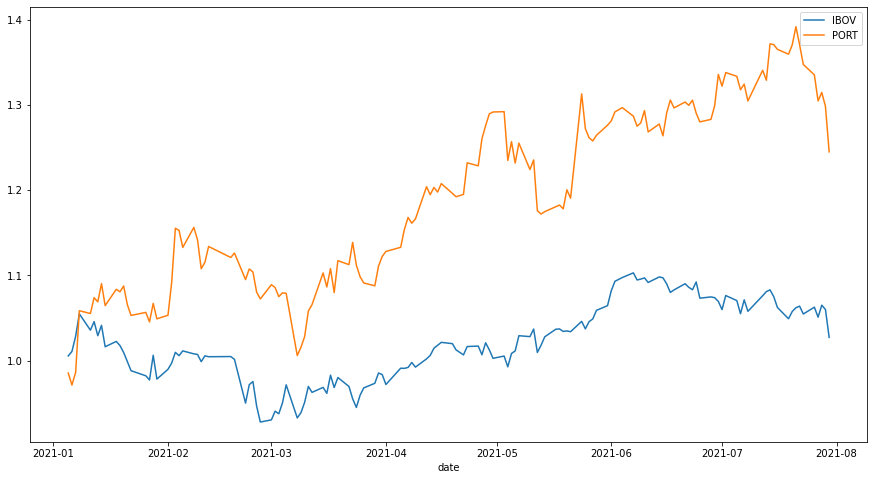

In [15]:
plot_df.cumsum().apply(np.exp).plot(figsize=(15,8))

In [19]:
plot_df.cumsum().apply(np.exp).values[-1]

array([1.0273537 , 1.24496892])

In [65]:
all_stocks = list(df.recomendations)

In [85]:
import scipy.optimize as sco

In [87]:
counter = 0
def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

def port_ret(weights):
    return np.sum(rets.mean() * weights) * 252

def min_func_sharpe(weights):
    return -port_ret(weights) / port_vol(weights) #função do sharpe ratio, que será minimizada

for i in range(0, len(all_stocks), 1):
    stocks = all_stocks[i]
    
    recs = []
    for stock in stocks.split('\n'):
        recs.append(stock.split("'")[1].split(" ")[-1])

    
    
    port = get_data(recs[0]+'.SA', start='2021-01-03', end='2021-07-31')[['close']] * weights[0] #creating the dataframe
    for (stock, weight) in zip(recs[1:], weights[1:]):
        data = get_data(stock+'.SA', start='2021-01-03', end='2021-07-31')[['close']]* weight

        port['close'] += data['close']
    
    port['Returns'] = np.log(port['close']/port['close'].shift(1))
    plot_df = pd.DataFrame()
    plot_df['IBOV'] = ibov_hist['Returns']
    plot_df['PORT'] = port['Returns']
    values = plot_df.cumsum().apply(np.exp).values[-1]
    print(plot_df.tail(1))
    print('Retorno do Portfolio: %.3f, retorno do Ibov: %.3f'%(values[-1]-1, values[0]-1))
    if values[-1]>values[0]:
        print('Bateu o Ibov!')
        counter+=1

                IBOV      PORT
date                          
2021-07-30 -0.031311 -0.024199
Retorno do Portfolio: 0.177, retorno do Ibov: 0.027
Bateu o Ibov!
                IBOV      PORT
date                          
2021-07-30 -0.031311 -0.028576
Retorno do Portfolio: 0.348, retorno do Ibov: 0.027
Bateu o Ibov!
                IBOV     PORT
date                         
2021-07-30 -0.031311 -0.02709
Retorno do Portfolio: 0.033, retorno do Ibov: 0.027
Bateu o Ibov!
                IBOV      PORT
date                          
2021-07-30 -0.031311 -0.024698
Retorno do Portfolio: 0.178, retorno do Ibov: 0.027
Bateu o Ibov!
                IBOV      PORT
date                          
2021-07-30 -0.031311 -0.031918
Retorno do Portfolio: 0.171, retorno do Ibov: 0.027
Bateu o Ibov!
                IBOV     PORT
date                         
2021-07-30 -0.031311 -0.01909
Retorno do Portfolio: 0.156, retorno do Ibov: 0.027
Bateu o Ibov!
                IBOV      PORT
date                 

                IBOV      PORT
date                          
2021-07-30 -0.031311 -0.023602
Retorno do Portfolio: 0.870, retorno do Ibov: 0.027
Bateu o Ibov!
                IBOV      PORT
date                          
2021-07-30 -0.031311 -0.064132
Retorno do Portfolio: 1.183, retorno do Ibov: 0.027
Bateu o Ibov!
                IBOV      PORT
date                          
2021-07-30 -0.031311 -0.031751
Retorno do Portfolio: 0.620, retorno do Ibov: 0.027
Bateu o Ibov!
                IBOV      PORT
date                          
2021-07-30 -0.031311 -0.030327
Retorno do Portfolio: 1.081, retorno do Ibov: 0.027
Bateu o Ibov!
                IBOV      PORT
date                          
2021-07-30 -0.031311 -0.011467
Retorno do Portfolio: 0.619, retorno do Ibov: 0.027
Bateu o Ibov!
                IBOV     PORT
date                         
2021-07-30 -0.031311 -0.05417
Retorno do Portfolio: 0.850, retorno do Ibov: 0.027
Bateu o Ibov!
                IBOV      PORT
date              

KeyError: 'close'

In [89]:
i

65